# Exercise 2 - The Right Fit (20 + 3 Points)

In this exercise you will learn about the goodness of fit to practically evaluate a set of statistical models. For this you will explore a new type of regression - the polynomial regression. With polynomial regression it is possible to fit a nonlinear relationship between the dependent and the independent variables, although the problem of estimating the parameters is linear and can be solved with the standard OLS approach.

The idea here is to learn a bunch of (polynomial) models on the same data set and explore the meaning of over- and underfitting the data. Key questions:

- What is overfitting and underfitting?
- How to detect it?
- How to prevent it?

In the event of a persistent problem, do not hesitate to contact the course instructors under
- paul.kahlmeyer@uni-jena.de

### Submission

- Deadline of submission:
        x.y.z

## Setup
We now have a new dataset saved as `train.npy`.

### Task 1 (1 Point)
Load this Dataset using the [`np.load`](https://numpy.org/doc/stable/reference/generated/numpy.load.html) function.

In [1]:
import numpy as np
# TODO: load train.npy (1 Point)
data = np.load("train.npy")
X = data[:,0]
Y = data[:,1]

Columns of the dataset represent the variables. Let `X` be the explanatory variable in the first column and `Y` be the variable we want to predict in the second column. 

### Task 2 (1 Point)
Visualize the data with a scatterplot of `X` against `Y`.

Text(0, 0.5, 'Y')

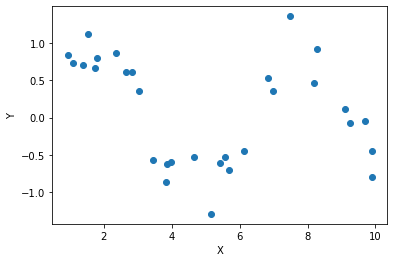

In [2]:
from matplotlib import pyplot as plt
# TODO: scatter plot the data (1 Point)
plt.scatter(X, Y)
plt.xlabel("X")
plt.ylabel("Y")

## Polynomial Regression
As you can see, the relationship between the dependent variable and the explanatory one does not seem to be linear and the standard linear regression from the lecture will not perform well. One way to account for such a non linear relationship is called [polynomial regression](https://en.wikipedia.org/wiki/Polynomial_regression). For a scalar explanatory variable `X` and a scalar dependent variable `Y`, the data generation model is:

$$
Y_i = \theta_0 + \theta_1 * X_i + \theta_2 X_i^2 + \dots + \theta_d X_i^d  + \epsilon_i = \sum_{j=0}^d \theta_i * X_i^j + \epsilon_i
$$
where $d$ is called degree. Although the relationship between the dependent and the explanatory variable is non linear, the problem of estimating the parameters $\theta$ is linear. By vectorizing the model, this becomes obvious:

$$
\begin{bmatrix}
    Y_1 \\
    Y_2 \\
    \vdots \\
    Y_n
\end{bmatrix}
=
\begin{bmatrix}
    1 & X_1 & X_1^2 & \dots & X_1^d \\
    1 & X_2 & X_2^2 & \dots & X_2^d \\
    \vdots & \vdots & \vdots &\ddots \\
    1 & X_n & X_n^2 & \dots & X_n^d
\end{bmatrix}
\begin{bmatrix}
    \theta_0 \\
    \theta_1 \\
    \vdots \\
    \theta_d
\end{bmatrix}
+
\begin{bmatrix}
    \epsilon_1 \\
    \epsilon_2 \\
    \vdots \\
    \epsilon_n
\end{bmatrix}
$$

This linear model can now be fit with the ordinary-least-squares MLE approach.

### Task 3 (2 Points)
Implement a function `poly` to create the design matrix for the polynomial regression. It should take two arguments:
- `X` : dataset $X_1,\dots,X_n$
- `degree`: degree of polynomial ($d$ from above definition)

and return the design matrix from the above definition.

Hints: Verify the correctness of your implementation!

In [3]:
def poly(x, degree):
    #TODO: return polynomial design matrix (2 Points)
    # polynomials: 1 Point
    # correct order: 1 Point
    return np.vander(x, degree+1, increasing=True)

x = np.array([1,2,3])
poly(x,3)

array([[ 1,  1,  1,  1],
       [ 1,  2,  4,  8],
       [ 1,  3,  9, 27]])

### Task 4 (2 Points)
Implement a function `fit_poly` to fit a polynomial model with ordinary least squares. Regularize your maximum-likelihood problem with the L2-norm of the parameters (see `Ridge regression` in the lecture notes). The function returns the parameter vector.

Hints:
- the only difference to the ridge regression from the lecture is the structure of the design matrix
- be aware of numerical pitfalls!

In [4]:
def fit_poly(x, y, degree, c=0):
    # TODO: estimate and return theta (2 Points)
    # correct formula: 1 Point
    # no inverse: 1 Point
    X = poly(x, degree)
    theta = np.linalg.solve(X.T @ X + c*np.eye(X.shape[1]), X.T @ y)
    return theta

## Visualisation
Next we want to fit a series of models of multiple degrees and visualise them alongside the data.

In [5]:
# model degrees
model_degrees = [0, 1, 2, 3, 6, 9, 12, 15, 18, 21]

# fit models
coeffs = [fit_poly(X, Y, degree, c=.0) for degree in model_degrees]

### Task 5 (3 Points)
Implement a function `predict_poly` that takes the estimated coefficients and datapoints $X$ as input. The function should then calculate the predictions $\hat{Y}$ for the dependent variable $Y$.
Visualise the 10 models alongside the data by plotting each model in a separate plot. Use a scatter plot for the data.

Hints:
- for `predict_poly` have a look at the equation system
- use the pyplot.subplot feature to fit multiple plots into one figure.
- use pyplot.tight_layout() to ensure the nice label rendering.
- if you had problems with the previous tasks, work with the numpy.polynomial module.

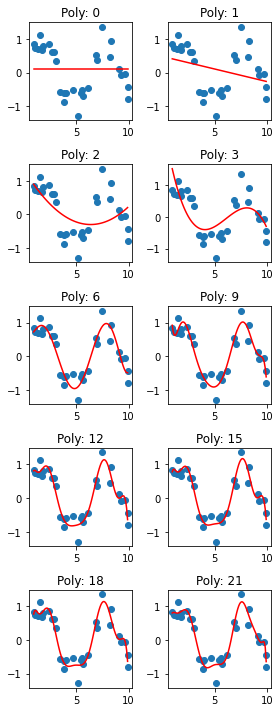

In [6]:
def predict_poly(X, coeffs):
    # TODO: predict and return Y (1 Point)
    degree = len(coeffs)-1
    return poly(X, degree) @ coeffs

def plot_coeffs(coeffs, X, Y):
    # TODO: plot data and regression line for different coeffs (2 Points)
    # Scatterplots: 1 Point
    # Regression lines: 1 Point
    nrows = (len(coeffs) + 1) // 2
    ncols = 2
    fs = 2
    plt.subplots(nrows=nrows, ncols=ncols, figsize=(fs*ncols, fs*nrows))
    for i, (degree, coeff) in enumerate(zip(model_degrees,coeffs)):
        # Scatterplot
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(f"Poly: {degree}")
        ax.scatter(X, Y)
        
        # Prediction
        X_p = np.linspace(min(X), max(X), 100)
        preds = predict_poly(X_p,coeff)
        ax.plot(X_p, preds, color="r")
    plt.tight_layout()
    
plot_coeffs(coeffs, X, Y)

## Model Validation
To evaluate the models, we need a measure of fit, that tells us how well the model fits the data. The standard measure for continuously distributed data is the "root mean squared error" (RMSE). Given the dependent variable $Y \in \mathbb{R}^n$ and its prediction $\hat{Y} = f(X, \theta) \in \mathbb{R}^n$, the RMSE is defined to be:

$$
RMSE(Y, \hat{Y}) = \sqrt{\frac{1}{n} \sum_{i}^n (Y_i - \hat{Y}_i)^2}
$$

### Task 6 (1 Point)
Implement a `rmse` function that returns the RMSE of a vector of observations $Y$ and its predictions $\hat{Y}$

In [7]:
def rmse(Y, Y_hat):
    # TODO: calculate RMSE
    return np.sqrt(np.mean((Y-Y_hat)**2))

Now we want to estimate, which polynomial estimation fits best to our data.
More complex models will in general yield better results on the data that was used to train them, but the quality of the model is determined by its "generalizability" ("how well does the model perform on data that it has not seen before?"). This concept of splitting the data is called <a href="https://en.wikipedia.org/wiki/Cross-validation_(statistics)">cross-validation</a>. In our case, it is sufficient to split the data in two sets:
- Training set (`train.npy`)
- Testing set (`test.npy`)

In [8]:
data_train = np.load("train.npy")
X_train = data[:,0]
Y_train = data[:,1]

data_test = np.load("test.npy")
X_test = data_test[:,0]
Y_test = data_test[:,1]

### Task 7 (3 Points)
To estimate the quality of our models:
- fit 20 polynomial models of degree 0 to 19 on the training data set.
- calculate the RMSE of all the models on the train data set. This error is called "training error"
- calculate the RMSE of all the models on the test data set. This error is called "validation error" or "cross-validation error"

In [9]:
# TODO: fit on training data (1 Point)
model_degrees = np.arange(0, 20, 1)
coeffs = [fit_poly(X_train, Y_train, degree, c=.0) for degree in model_degrees]

# TODO: RMSE on train data (1 Point)
training_errors = [rmse(Y_train, predict_poly(X_train, coeff)) for degree, coeff in zip(model_degrees, coeffs)]
    
# TODO: RMSE on test data (1 Point)
validation_errors = [rmse(Y_test, predict_poly(X_test, coeff)) for degree, coeff in zip(model_degrees, coeffs)]

### Task 8 (1 Point)
Now visualize the training RMSE and testing RMSE in dependence of the degree of the models.

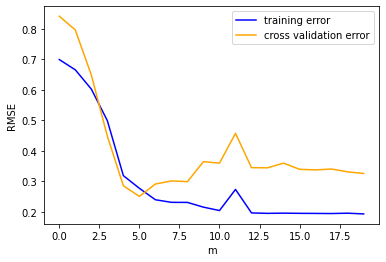

In [10]:
# TODO: plot RMSE against polynomial degree
plt.plot(model_degrees, training_errors, color="b", label="training error")
plt.plot(model_degrees, validation_errors, color="orange", label="cross validation error")
plt.xlabel("m")
plt.ylabel("RMSE")
plt.legend()

## Overfit and Underfit
From the two curves of the previously generated figure you can determine the fit of the models.
- Underfitting: training and cross validation error are high
- Overfitting: training error is low, cross validation is high
- Just right: training and cross validation errors are low

### Task 9 (1 Point)
List briefly:
- which models underfit: degree<4
- which models overfit: degree>6
- which models fit just right: degree 4,5

# Regularization with diamonds

In exercise1, you fit a linear model with the diamonds data set. One way to enforce the right fit is by using regularization.

In [11]:
import pandas as pd
data = pd.read_csv("diamonds.csv")
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### Dataset
- price: price in US dollars (326.0 - 18823.0)
- carat: weight of the diamond (0.2 - 5.01)
- cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color: diamond colour, from J (worst) to D (best)
- clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- x: length in mm (0--10.74)
- y: width in mm (0--58.9)
- z: depth in mm (0--31.8)
- depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- table: width of top of diamond relative to widest point (43--95)

## Data transformations

The following table lists data transformations in dependence of the feature type. They can be used to include discrete features into a regression model.

<table>
  <tr>
    <th>Feature type</th>
    <th>Transformation</th>
  </tr>
  <tr>
    <td>Nominal: categorical, unordered<br>features (True or False)</td>
    <td>One-hot encoding (0, 1)</td>
  </tr>
  <tr>
    <td>Ordinal: categorical, ordered<br>features (movie ratings)</td>
    <td>Ordinal encoding (0, 1, 2, 3, ...)</td>
  </tr>
</table>

### Task 10 (2 Points)
In the diamonds set there are several ordinal variables. Encode them corretly such that they can be used for our regression.

Hint: 
- There are multiple pre-implemented ways to do that. E.g. ([`dict vectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html), [`label encoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), ...)
- The easiest way to do that may be the [`map`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html) functions from pandas series (if you index the dataframe by a column name, you get a series)

In [12]:
# TODO: Encode discrete variables from dataset (2 Points)
# ordinal encoding: 1 Point
# correctness: 1 Point 
cut_map = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
color_map = {'D': 6, 'E': 5, 'F': 4, 'G': 3, 'H': 2, 'I': 1, 'J': 0}
clarity_map = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}

data['cut'] = data['cut'].map(cut_map)
data['color'] = data['color'].map(color_map)
data['clarity'] = data['clarity'].map(clarity_map)

### Task 11 (1 Point)
Split the dataset into a train set (80%) and a test set (20%). 

Hint: You can use the [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [13]:
# TODO: split data into train and testset
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data.drop(["price"], axis=1), data["price"], test_size=0.2, random_state=0)

### Task 12 (1 Point)
Fit a linear model with L2 regularization with regularization parameter $\alpha=0.5$ to the train set.

Hint: You can use the [`sklearn.linear_model.Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) class for that.

In [14]:
# TODO: fit linear model with ridge regression
from sklearn.linear_model import Ridge
rr = Ridge(alpha=0.5)
rr.fit(X_train, Y_train)

Ridge(alpha=0.5)

### Task 13 (1 Point)
Calculate the RMSE on the train set and on the test set. Compare them.

In [15]:
# TODO: calculate and compare RMSE on train- and testset
Y_train_predict = rr.predict(X_train)
Y_test_predict = rr.predict(X_test)
print("RMSE_train", rmse(Y_train, Y_train_predict))
print("RMSE_test", rmse(Y_test, Y_test_predict))

RMSE_train 1221.1511212042326
RMSE_test 1198.2715983320113


## Hyperparameters (BONUS TASKS)

Finding the right regularization parameter is a optimization problem on its on.

### Bonustask 1 (1 Point)
Calculate the RMSE on the train set for increasing values for the regularization parameter $\alpha$.
Plot the results.

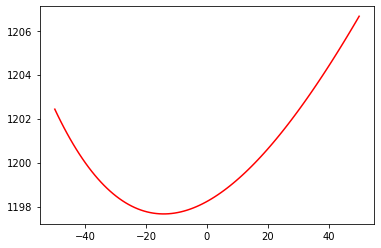

In [16]:
# BONUS: calculate + plot test RMSE for range of alpha
# Different regularization parameters
alphas = np.linspace(-50, 50, 100)

# Validation RMSEs
rmses = []
for alpha in alphas:
    rr = Ridge(alpha=alpha)
    rr.fit(X_train, Y_train)
    Y_test_predict = rr.predict(X_test)
    rmses.append(rmse(Y_test, Y_test_predict))
    
plt.plot(alphas, rmses, color="red")

We obviously want to use the value of $\alpha$, that minimizes the RMSE.

### Bonustask 2 (2 Points)
- implement a function `alpha_loss` that takes the regularization parameter $\alpha$ as argument and returns the RMSE of the associated model for the test data set.
- minimize this function with respect to the regularization parameter.
- which parameter yields the perfect fit?

Hint: Check out [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function.

In [17]:
def alpha_loss(alpha):
    # BONUS: calculate test RMSE (1 Point)
    rr = Ridge(alpha=alpha)
    rr.fit(X_train, Y_train)
    Y_test_predict = rr.predict(X_test)
    return rmse(Y_test, Y_test_predict)

# BONUS: minimize alpha_loss function (1 Point)
from scipy.optimize import minimize
res = minimize(fun=alpha_loss, x0=np.array([0]), jac=False)
min_param = res.x[0]
min_RMSE = res.fun
print(f'Minimal at alpha={min_param} with RMSE of {min_RMSE}')

Minimal at alpha=-14.227745818255963 with RMSE of 1197.6650344447617
